# NLP Project - EFR in English conversations

You can find the ppt with details and requirements of the project <a href="https://docs.google.com/presentation/d/1TTN1H3GdnaswGXW63SuSvD4CsI7HB9lkYuwXRMQp2ks/edit?usp=sharing"> here</a>. The ppt is equivalent to the <a href="https://virtuale.unibo.it/mod/page/view.php?id=1405067"> FAQ page</a>

You can find the official webpage of the challenge <a href="https://lcs2.in/SemEval2024-EDiReF/"> here</a>

**EFR: Given a dialogue, EFR aims to identify the trigger utterance(s) for an emotion-flip in a multi-party conversation dialogue.** 

For example: 
<center>
    <img src="./images/example_EFR.jpeg" alt="EFR" />
</center>

In [17]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy
import os
import torch
from sys import platform
from utilities import *

from models.randomClassifier import RandomClassifier
from models.majorityClassifier import MajorityClassifier

from DrTorch.metrics import F1_Score_Multi_Labels
from models.bertFreezed import BertFreezed
from models.bertFull import BertFull


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setting the device

In [18]:
print(f"PyTorch version: {torch.__version__}")

if platform == "darwin":    #Run on macOS
    
    print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
    print(f"Is MPS available? {torch.backends.mps.is_available()}")
    device = "mps" if torch.backends.mps.is_available() else "cpu"    
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

print(f"Using device: {device}")


PyTorch version: 2.2.0+cu121
Using device: cuda


In [19]:
if device != 'mps':
    !nvidia-smi


Wed Feb 21 17:59:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.23                 Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   42C    P8               5W /  40W |      0MiB /  8188MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Defining flags and variables

In [20]:
DATA_DIRECTORY = 'Data'             # Directory containing the dataset
DATASET = 'MELD_efr.json'           # Name of dataset file

BERT_DIRECTORY = "bert-base-uncased"

DATASET_PATH = os.path.join(DATA_DIRECTORY, DATASET)    # Path of dataset in JSON format 


## Dataset Creation and Exploration

In [21]:
df = pd.read_json(DATASET_PATH)
df.set_index("episode", inplace=True)

df


,speakers,emotions,utterances,triggers
episode,,,,
utterance_0,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_1,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_2,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
utterance_3,"[Chandler, The Interviewer, Chandler, The Inte...","[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_4,"[Joey, Rachel, Joey, Rachel]","[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"
...,...,...,...,...
utterance_3995,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3996,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3997,"[Chandler, All, Monica, Chandler, Ross, Chandl...","[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [22]:
display_utterance(dataframe=df, utterance_id='utterance_3491')
display_utterance(dataframe=df, utterance_id='utterance_456')
display_utterance(dataframe=df, utterance_id='utterance_2005')


Utterance 3491


,speakers,emotions,utterances,triggers
0,Phoebe,surprise,You-you you had sex with Ursula?!,0.0
1,Eric,fear,"Uh, a little bit. She-she-she walked in and I ...",0.0
2,Phoebe,surprise,You didn't notice she was wearing different cl...,1.0
3,Eric,sadness,Well I was just so excited to see you.,0.0



Utterance 456


,speakers,emotions,utterances,triggers
0,Kate,joy,Become a drama critic!,0.0
1,The Director,sadness,I am hurt! A plague on both your houses!,0.0
2,Kate,sadness,"By the way, he dumped me tonight after he read...",0.0
3,Joey,disgust,"Oh, classy.",0.0
4,Kate,sadness,"Yep! I sure know how to pick em, huh? Y'know ...",0.0
5,Joey,anger,"Wow! Yeah I ah, I gave up a job too.",0.0
6,Kate,surprise,Really. What?,0.0
7,Joey,anger,"Uh, de-clawing cats.",0.0
8,Joey,neutral,"Hey, tell ya what.",0.0



Utterance 2005


,speakers,emotions,utterances,triggers
0,Chandler,neutral,"Where you going, Joe?",0.0
1,Joey,neutral,For a walk.,0.0
2,Chandler,neutral,Oh. You mind if I join you?,0.0
3,Joey,neutral,"Actually, that will be long. You know, I reall...",0.0
4,Chandler,surprise,Your thoughts? Plural?,1.0
5,Joey,joy,"Allright, fine, I only have one thought! It's ...",1.0


[START] frase1_dialogo1 [SEP] frase2_dialogo1 [SEP] ... [END]
[START] frase1_dialogo2 [SEP] ...
...

Frase, speaker, id_dialogo

In [23]:
# removing NaN values
nan_count_before = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()
df['triggers'] = df['triggers'].apply(replace_nan_with_zero)
nan_count_after = df["triggers"].apply(lambda lst: sum(pd.isna(x) for x in lst)).sum()

print(f"Before: {nan_count_before} NaN values")
print(f"After: {nan_count_after} NaN values")


Before: 9 NaN values
After: 0 NaN values


In [24]:
total_n_speakers = list(set(df['speakers'].explode()))
speakers = {'min_speakers': 'inf', 'max_speakers': '-inf'}
utterances = {'length_min': 'inf', 'length_max': '-inf'}

num_unique_speakers = df['speakers'].apply(lambda x: len(set(x)))
speakers['min_speakers'] = num_unique_speakers.min()
speakers['max_speakers'] = num_unique_speakers.max()

len_utterances = df['utterances'].str.len() 
utterances['length_min'] = len_utterances.min()
utterances['length_max'] = len_utterances.max()
    
        
print(f"Number of unique speakers: {len(total_n_speakers)}\n")
print(f"Minimum number of speakers in an utterance: {speakers['min_speakers']}")
print(f"Maximum number of speakers in an utterance: {speakers['max_speakers']}\n")
print(f"Minimum number of sentences in an utterance: {utterances['length_min']}")
print(f"Maximum number of sentences in an utterance: {utterances['length_max']}")

Number of unique speakers: 231

Minimum number of speakers in an utterance: 1
Maximum number of speakers in an utterance: 8

Minimum number of sentences in an utterance: 2
Maximum number of sentences in an utterance: 24


In [25]:
train_df, val_df, test_df = split_dataset(df)

display(train_df.head())
display(val_df.head())
display(test_df.head())


,speakers,emotions,utterances,triggers
index,,,,
utterance_555,"[Phoebe, Phoebe]","[sadness, anger]","[Look, I feel really bad about how I freaked y...","[0.0, 0.0]"
utterance_3491,"[Phoebe, Eric, Phoebe, Eric]","[surprise, fear, surprise, sadness]","[You-you you had sex with Ursula?!, Uh, a litt...","[0.0, 0.0, 1.0, 0.0]"
utterance_527,"[Mona, Ross, Dr. Green, Ross]","[fear, neutral, anger, sadness]","[Oh my God! Oh my God! I'm so sorry!, Aw forge...","[0.0, 0.0, 1.0, 0.0]"
utterance_3925,"[Chandler, Chandler, Chandler, Chandler]","[neutral, neutral, neutral, disgust]","[I can blow dry it., I can put gel on it., It ...","[0.0, 0.0, 1.0, 0.0]"
utterance_2989,"[Ross, Phoebe, Ross]","[joy, joy, neutral]",[You're gonna love me so much. I got Sting tic...,"[0.0, 1.0, 0.0]"


,speakers,emotions,utterances,triggers
index,,,,
utterance_3334,"[Rachel, Tag, Rachel]","[surprise, neutral, joy]","[Oh really?!, Yeah. Did you tell someone that ...","[0.0, 1.0, 0.0]"
utterance_652,"[Phoebe, Duncan, Phoebe, Duncan, Phoebe]","[neutral, surprise, joy, neutral, neutral]","[Hi., Phoebe!, Ta-da., Hey., Hi.]","[0.0, 0.0, 0.0, 1.0, 0.0]"
utterance_172,"[Monica, Joey, Monica, Phoebe, Rachel, Joey, R...","[joy, surprise, anger, surprise, neutral, neut...","[Because we won our apartment back!, What? Ace...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_3197,"[Older Scientist, Ross, Ross, Joey, Ross, Ross]","[neutral, neutral, neutral, neutral, neutral, ...","[Dr. Geller, there's a seat over here., Thank ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0]"
utterance_38,"[Chandler, Jade, Jade, Chandler]","[neutral, neutral, neutral, joy]","[What've you been up to?, Oh, you know, the us...","[0.0, 1.0, 1.0, 0.0]"


,speakers,emotions,utterances,triggers
index,,,,
utterance_3881,"[Joey, Monica, Joey, All, Monica, Joey, Rachel...","[neutral, neutral, joy, disgust, disgust, sadn...","[Hey, y'know what a really good rainy day game...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_2848,"[Janice, Chandler, Janice, Chandler, Janice, C...","[surprise, neutral, surprise, neutral, anger, ...","[Are you being British?!, No. Not anymore., Wh...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ..."
utterance_1603,"[Rachel, Rachel, Rachel, Ross, Ross, Ross, Ros...","[sadness, sadness, sadness, neutral, neutral, ...",[I'm guess I'm just done with the whole dating...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
utterance_160,"[Mr. Tribbiani, Joey, Mr. Tribbiani, Joey]","[sadness, surprise, neutral, neutral]","[Gotta go. I miss you too, I love you, but it'...","[0.0, 0.0, 1.0, 0.0]"
utterance_1704,"[Rachel, Chandler, Rachel, Chandler, Rachel]","[joy, anger, neutral, sadness, surprise]","[Hi!, Another cheesecake came! They delivered ...","[0.0, 0.0, 0.0, 1.0, 0.0]"


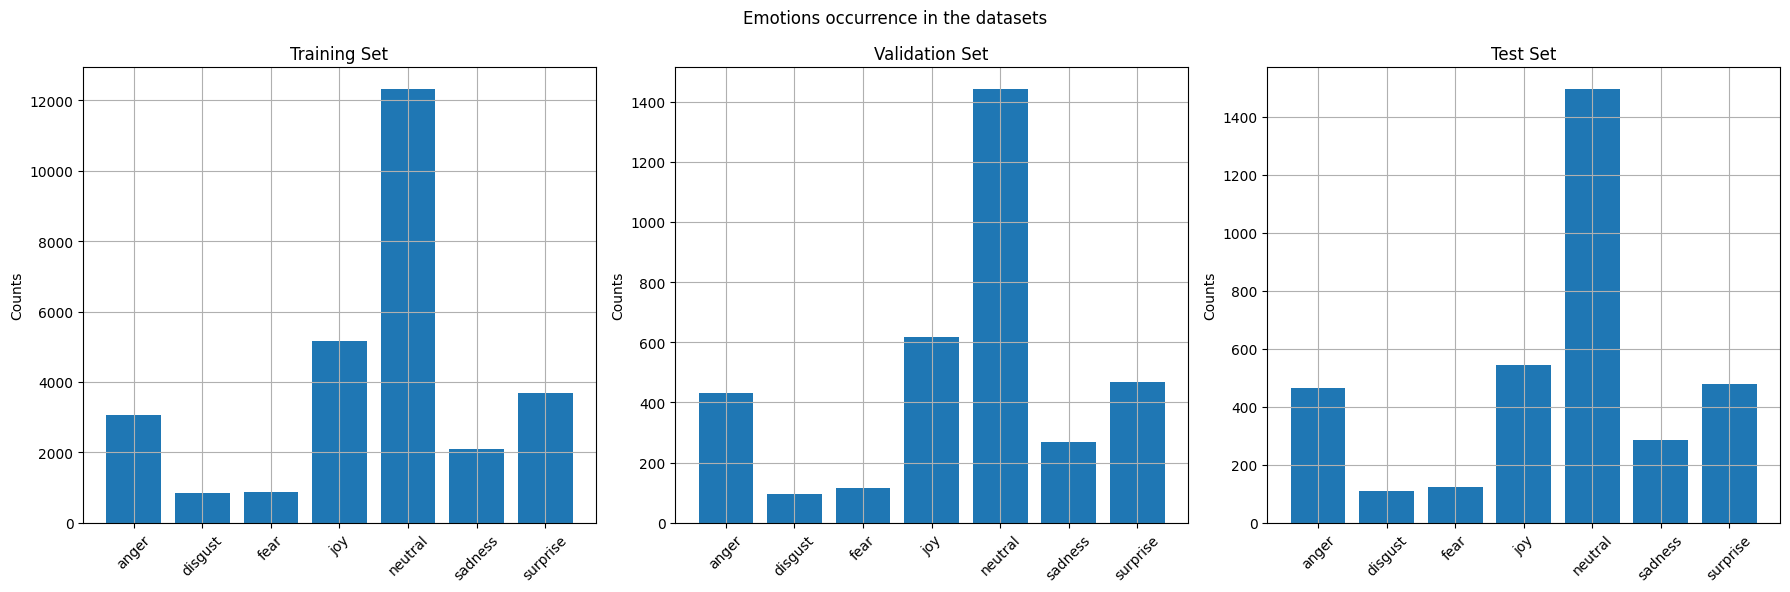

In [26]:
plot_emotion_distribution(train_df, val_df, test_df)


In [27]:
# todo heatmap che associa a ogni personaggio il conto di emozioni che lo riguardano. Ogni riga contiene un'emozione, ogni colonna un personaggio. Esempio:
# Kristen -> (angry-40 volte), (joy, 20 volte), (disgust, 70 volte)...
# Joey -> (angry-23 volte), (joy, 50 volte) ...

# può essere interessante da fare per far vedere che facendo l'embedding dei singoli nomi distintamente il modello avrebbe il bias del nome (magari kristen porta molto disgusto, quindi tende ad assegnarglielo più facilmente)

## Random Classifier

In [28]:
# todo metric computation

emotions = np.unique([item for sublist in df["emotions"] for item in sublist]) # flattening and taking unique emotions
random_classifier = RandomClassifier(emotions)

pred_emotions, pred_triggers = random_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona

new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_utterance(dataframe=new_test_df, utterance_id='utterance_3881')
    

Utterance 3881


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,neutral,"Hey, y'know what a really good rainy day game is?",0.0,joy,0
1,Monica,neutral,What?!,0.0,sadness,0
2,Joey,joy,"I mean naked game. Strip poker, we should tota...",0.0,neutral,1
3,All,disgust,"No, no!",0.0,sadness,1
4,Monica,disgust,What are you crazy?!,0.0,fear,0
5,Joey,sadness,"Come on! When you go away, you-you have to pla...",0.0,neutral,1
6,Rachel,neutral,Allll done!,0.0,sadness,1
7,Monica,joy,"Aww, thank you.",0.0,surprise,0
8,Rachel,neutral,"Okay, who's next?!",0.0,sadness,1
9,Ross,disgust,No-o-o! No way!,0.0,disgust,1


## Majority Classifier

In [29]:
# todo metrics computation

majority_classifier = MajorityClassifier()

majority_classifier.fit(train_df)
pred_emotions, pred_triggers = majority_classifier.predict(test_df)

# esempio di print per gli scettici che non crederanno che il classifier funziona
new_test_df = test_df.copy()
new_test_df['pred_emotions'] = pred_emotions
new_test_df['pred_triggers'] = pred_triggers
display_utterance(dataframe=new_test_df, utterance_id='utterance_3881')



Utterance 3881


,speakers,emotions,utterances,triggers,pred_emotions,pred_triggers
0,Joey,neutral,"Hey, y'know what a really good rainy day game is?",0.0,neutral,0.0
1,Monica,neutral,What?!,0.0,neutral,0.0
2,Joey,joy,"I mean naked game. Strip poker, we should tota...",0.0,neutral,0.0
3,All,disgust,"No, no!",0.0,neutral,0.0
4,Monica,disgust,What are you crazy?!,0.0,neutral,0.0
5,Joey,sadness,"Come on! When you go away, you-you have to pla...",0.0,neutral,0.0
6,Rachel,neutral,Allll done!,0.0,neutral,0.0
7,Monica,joy,"Aww, thank you.",0.0,neutral,0.0
8,Rachel,neutral,"Okay, who's next?!",0.0,neutral,0.0
9,Ross,disgust,No-o-o! No way!,0.0,neutral,0.0


## Bert Models

In [32]:
EMOTIONS = np.unique([item for sublist in df["emotions"] for item in sublist])
EMOTIONS_TO_INT = {i: emotion for (emotion, i) in enumerate(EMOTIONS)}
INT_TO_EMOTIONS = {emotion: i for (emotion, i) in enumerate(EMOTIONS)}

print("Aaahhh le emozioni: ", EMOTIONS)

Aaahhh le emozioni:  ['anger' 'disgust' 'fear' 'joy' 'neutral' 'sadness' 'surprise']


In [31]:
# first execution it downloads bert model and tokenizer, from second execution it retrieves them from local folder
if os.path.exists(BERT_DIRECTORY):
    bert_model, bert_tokenizer = retrieve_bert_initializers(BERT_DIRECTORY) 
else:
    bert_model, bert_tokenizer = download_bert_initializers(BERT_DIRECTORY) 

In [ ]:
"""econded_df = pd.DataFrame()
econded_df["utterances"] = df['utterances'].apply(lambda x: tokenize_sentences(tokenizer, x))

prova = build_dataloader(test_df, bert_tokenizer, 2, EMOTIONS_TO_INT, True)

bertino = BertFreezed()"""